In [1]:
import pandas as pd
from sktime.forecasting.all import ForecastingHorizon
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings( 'ignore' )

### Load Data

In [2]:
y =pd.read_csv('hw4_data.csv', index_col=0)
y

,co2
ds,
1958-03-15,315.700
1958-04-15,317.450
1958-05-15,317.510
1958-06-15,316.685
1958-07-15,315.860
...,...
2019-01-15,410.920
2019-02-15,411.660
2019-03-15,412.000


## Clean Data converting y index pd.to_datetime()
    y.index = pd.core.indexes.period.PeriodIndex(y.index, freq='m')

In [3]:
# y.index = pd.to_datetime( y.index)
y.index = pd.core.indexes.period.PeriodIndex(y.index, freq='m')
y

,co2
ds,
1958-03,315.700
1958-04,317.450
1958-05,317.510
1958-06,316.685
1958-07,315.860
...,...
2019-01,410.920
2019-02,411.660
2019-03,412.000


### Import AutoArima

In [4]:
from sktime.forecasting.all import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.all import temporal_train_test_split

## Separate Train and Test Using Temporal Train Test. Use a train_size of 5

### Make a One Step Rolling Auto Arima

In [5]:
class RollingFit:
    def __init__(self, y, train_size=551, model=AutoARIMA() ):
        
        self.y = y
        self.model = model
        
        self.train_y, self.test_y = temporal_train_test_split(y, train_size=train_size)
#         print(self.train_y.shape)
        self._test_y = self.test_y
        self.ypred_ = self.train_y
        self.fit()
        
    def fit(self):
        N = len( self.test_y )
#         print(N)
        for i in range(0, N):
#             print(i)
            self.fit_model()
            ypred = self.predict_one()
            self.add_to_predictions( ypred )
            self.move_one_test_to_train()
            self.drop_one_from_test()
    
    
    def fit_model(self):
        y = self.train_y
        self.model.fit( y )
        
    def predict_one(self):
        ypred = self.model.predict(1)
        return ypred
    
    def add_to_predictions(self, ypred):
        self.ypred_ = pd.concat([self.ypred_, ypred])
        
        
    def move_one_test_to_train(self):
        series_to_add = pd.Series( 
            self.test_y[0], 
            index = [ self.test_y.index[0] ] 
        )
        self.train_y = pd.concat( [self.train_y, series_to_add ])    
    
    def drop_one_from_test(self):
        self.test_y = self.test_y[1:]

In [6]:
rolling_fit_model = RollingFit(y['co2'], model=ARIMA((1,1,1), seasonal_order=(0,1,1,12) ))

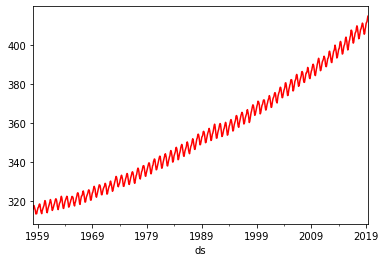

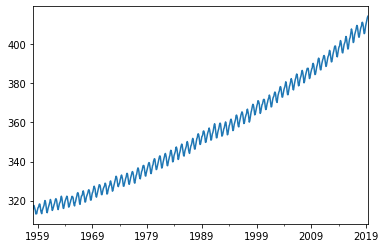

In [7]:
rolling_fit_model.y.plot(color='red')
plt.show()
rolling_fit_model.ypred_.plot()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math
from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import mape_loss

In [9]:
import numpy as np
def MASE(training_series, testing_series, prediction_series):
   
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


In [10]:
rolling_fit_model.train_y

1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2019-01    410.920
2019-02    411.660
2019-03    412.000
2019-04    413.510
2019-05    414.830
Freq: M, Length: 735, dtype: float64

In [11]:
y_test_set=rolling_fit_model.train_y[551:]
y_test_set

2004-02    377.37
2004-03    378.39
2004-04    380.50
2004-05    380.62
2004-06    379.55
            ...  
2019-01    410.92
2019-02    411.66
2019-03    412.00
2019-04    413.51
2019-05    414.83
Freq: M, Length: 184, dtype: float64

In [12]:
y_pred_set=rolling_fit_model.ypred_[551:]
y_pred_set

2004-02    377.642455
2004-03    378.250163
2004-04    379.682499
2004-05    380.825401
2004-06    380.147418
              ...    
2019-01    410.411151
2019-02    411.476707
2019-03    412.358237
2019-04    413.729440
2019-05    414.359156
Freq: M, Length: 184, dtype: float64

In [13]:
mae = mean_absolute_error(y_test_set, y_pred_set)
mse = mean_squared_error(y_test_set, y_pred_set)
rmse = math.sqrt(mse)
smape = smape_loss(y_test_set, y_pred_set)
mape = mape_loss(y_test_set, y_pred_set)
mase= MASE(rolling_fit_model.train_y, y_test_set, y_pred_set)

In [14]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 0.12701416960617812
Root Mean Squared Error: 0.35639047350648717
Mean Absolute Error: 0.2746876521690032
SMAPE: 0.0006978684049097219
MAPE: 0.0006978306470994643
MASE: 0.24774306266916693


In [25]:
class RecursiveForecast:
    def __init__(self, y, train_size=551, model=AutoARIMA() ):
        
        self.y = y
        self.model = model
        self.train_y, self.test_y = temporal_train_test_split(y, train_size=train_size)
        self._test_y = self.test_y
        self.ypred_ = self.train_y
        self.fit()
        
    def fit(self):
        N = len( self.test_y )
        for i in range(0, N):
            self.fit_model()
            ypred = self.predict_one()
            self.add_to_predictions( ypred )
            self.move_one_pred_to_train(ypred)
#             print(self.train_y)
            self.drop_one_from_test()
    
    
    def fit_model(self):
        y = self.train_y
        self.model.fit( y )
        
    def predict_one(self):
        ypred = self.model.predict(1)
        return ypred
    
    def add_to_predictions(self, ypred):
        self.ypred_ = pd.concat([self.ypred_, ypred])
        
        
    def move_one_pred_to_train(self,prediction):
        series_to_add = pd.Series( 
            prediction, 
            index = [ self.test_y.index[0] ] 
        )
        self.train_y = pd.concat( [self.train_y, series_to_add ])    
    
    def drop_one_from_test(self):
        self.test_y = self.test_y[1:]

In [26]:
recursive_model = RecursiveForecast(y['co2'], model=ARIMA((1,1,1), seasonal_order=(0,1,1,12) ))

In [27]:
original_data=pd.Series(y['co2'])
original_data.index.name=None
original_data

1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2019-01    410.920
2019-02    411.660
2019-03    412.000
2019-04    413.510
2019-05    414.830
Freq: M, Name: co2, Length: 735, dtype: float64

In [28]:
y_test_set=original_data[551:]
y_test_set

2004-02    377.37
2004-03    378.39
2004-04    380.50
2004-05    380.62
2004-06    379.55
            ...  
2019-01    410.92
2019-02    411.66
2019-03    412.00
2019-04    413.51
2019-05    414.83
Freq: M, Name: co2, Length: 184, dtype: float64

In [29]:
recursive_model.ypred_

1958-03    315.700000
1958-04    317.450000
1958-05    317.510000
1958-06    316.685000
1958-07    315.860000
              ...    
2019-01    409.144808
2019-02    410.006409
2019-03    410.826008
2019-04    412.178841
2019-05    412.811939
Freq: M, Length: 735, dtype: float64

In [30]:
y_pred_set=recursive_model.ypred_[551:]
y_pred_set

2004-02    377.642455
2004-03    378.431562
2004-04    379.752355
2004-05    380.353022
2004-06    379.874342
              ...    
2019-01    409.144808
2019-02    410.006409
2019-03    410.826008
2019-04    412.178841
2019-05    412.811939
Freq: M, Length: 184, dtype: float64

In [31]:
mae = mean_absolute_error(y_test_set, y_pred_set)
mse = mean_squared_error(y_test_set, y_pred_set)
rmse = math.sqrt(mse)
smape = smape_loss(y_test_set, y_pred_set)
mape = mape_loss(y_test_set, y_pred_set)
mase= MASE(original_data, y_test_set, y_pred_set)

In [32]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 0.4441635088178957
Root Mean Squared Error: 0.6664559316398164
Mean Absolute Error: 0.4935730961434671
SMAPE: 0.001239812725483191
MAPE: 0.00123894712218656
MASE: 0.44515765278904007
